In [526]:
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing
import datetime as dt
from sklearn import model_selection, metrics
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pickle
%matplotlib inline

## Loading data and building features

In [527]:

# Load dataset 
train = pd.read_csv('asset/train.csv')
test = pd.read_csv('asset/test.csv')
sample = pd.read_csv('asset/sampleSubmission.csv')
weather = pd.read_csv('asset/weather.csv')
spray = pd.read_csv('asset/spray.csv')

# Get labels
labels = train.WnvPresent.values

# Creating dummy variables for the weather data
weather.CodeSum = weather.CodeSum.apply(str.split)
for (i,list_) in enumerate(weather.CodeSum):
    for item in list_:
        if item not in weather.columns:
            weather[item] = 0
        weather.set_value(col=item,index=i,value=1)


# Not using codesum anymore
weather = weather.drop('CodeSum', axis=1)
# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)
weather.Date = pd.to_datetime(weather.Date)
spray.Date = pd.to_datetime(spray.Date)


In [528]:
# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', 0)
weather = weather.replace(' T', 0)
weather = weather.replace('  T', 0)

In [529]:
weather['yoni_interaction_term'] = (weather.DewPoint_x)/(weather.Tavg_x.apply(float))
#weather['yoni_interaction_term_y'] = (weather.DewPoint_y)/(weather.Tavg_y.apply(float))

In [530]:
# Taking derivities of some columns
weather['tmax_diff'] = weather.Tmax_x.diff()
weather['dewpoint_diff'] = weather.DewPoint_x.diff()
weather['tmin_diff'] = weather.Tmin_x.diff()
#weather['wetbulb_diff'] = weather.WetBulb_x().apply(float).diff()
weather['precip_diff'] = weather.PrecipTotal_x.apply(float).diff()
weather['tavg_diff'] = weather.Tavg_x.apply(float).diff()

In [531]:
# Functions to extract month and day from dataset
train['year'] = train['Date'].dt.year
train['month'] = train['Date'].dt.month
train['day'] = train['Date'].dt.day
test['year'] = test['Date'].dt.year
test['month'] = test['Date'].dt.month
test['day'] = test['Date'].dt.day

In [532]:
# drop address columns
train = train.drop(['Address', 'AddressNumberAndStreet','WnvPresent', 'NumMosquitos'], axis = 1)
test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

In [533]:
# This method merges the weather df with a dataframe and does so mulitple times by days for the given amount
# of days
def merge_weather_previous_days(df, days, df_weather = weather):
    for i in range(1, days):
        date_col = 'Date'+ '_' + str(i)
        if(i == 0):
            date_col = 'Date'
        df[date_col] = df.Date.apply(lambda a: a - pd.Timedelta(days=1))
        df = df.merge(weather, left_on=date_col, right_on='Date', suffixes=("","_day_" + str(i)))
    return df


def merge_weather_previous_weeks(df, weeks, df_weather = weather):
    for i in range(1, weeks):
        date_col = 'Date'+ '_' + str(i)
        if(i == 0):
            date_col = 'Date'
        df[date_col] = df.Date.apply(lambda a: a - pd.Timedelta(weeks=1))
        df = df.merge(weather, left_on=date_col, right_on='Date', suffixes=("","_week_" + str(i)))
    return df


# #This method is attempting to take the mean of weather over a weekly period, and append that values to our DF
# def agg_by_week(df, df_weather = weather):
#     # grouping data in weather column by week and taking the average.
#     # i'm going to use this data to build columns in the passed in data frame that has the average value
#     # of the 
#     agg_weather = df_weather.set_index('Date').groupby(pd.TimeGrouper('W')).mean()
#     for d in agg_weather.index:
#         for c in agg_weather:
#             if c not in df.columns:
#                 df[c] = agg_weather.get_value(d, c)
#             for j in range(1, len(df)):
#                 if df.get_value(j, "Date") < d:
#                     if df.get_value(j-1, "Date") > d:
#                         df.set_value(j, c, agg_weather.get_value(d,c))
#                 else:
#                     break
                    
#This method is attempting to take the mean of weather over a weekly period, and append that values to our DF
def agg_by_week(df, df_weather = weather):
    # grouping data in weather column by week and taking the average.
    # i'm going to use this data to build columns in the passed in data frame that has the average value
    # of the 
    for i in range(0, len(df)):
        df_date = df.get_value(i, 'Date')
        agg_weather = df_weather.set_index('Date').groupby(pd.TimeGrouper('W')).mean()
        for c in agg_weather.columns:
            col_name = c+ "_agg"
            if c.startswith('codesum'):
                continue
            if c not in df.columns:
                df[col_name] = -1
            value =  agg_weather[c][(agg_weather.index < df_date) & 
                                (agg_weather.index > df_date - pd.Timedelta(weeks=1))][0]
            #print(value)
            if np.isnan(value):
                value = -1
            df.set_value(i, col_name, value)

In [534]:
# Putting historical weather data onto the data frame
train = merge_weather_previous_days(train, 3, weather)
test =  merge_weather_previous_days(test, 4, weather)

train = merge_weather_previous_weeks(train, 3, weather)
test =  merge_weather_previous_weeks(test, 4, weather)



In [535]:
# This function allows you to create columns for the data_df input that will have a value of 1 or zero
# If a trap has been sprayed with in the time period specified

def create_sprayed_cols(data_df, spray_df, time_period=2):
    # Iterating over unique dates that sprays took place
    # Sprays took place over 10 days as trucks drove around chicago
    for date in set(spray_df.Date):
        # I only want data for this unique date
        spray_temp = spray_df[spray_df.Date == date]
        # Resetting index to make iterating easier
        spray_temp.index = range(0, len(spray_temp))
        
        # I am creating a column for every unique date and initalizing it's rows to 0
        # I will set these values to 1 when I find a trap that was sprayed
        col_name = 'spray_'+date.strftime('%Y-%m-%d')+"_"+str(time_period)
        data_df[col_name] = 0
        # Iterating over each row of our training data to determine if a trap is in the location
        # of a spray. I am also checking to see if the spray was in the past
        for r in range(0,len(data_df)):
            if data_df.get_value(r,'Date') > date and data_df.get_value(r,'Date') < date + pd.Timedelta(weeks=time_period):

                # I am casting the lat and long to ints, and multiplaying by 100 to truncate precision
                # In other words, I'm taking pin points and making them into squares
                cur_lat = int(data_df.get_value(r, 'Latitude') * 100)
                cur_long = int(data_df.get_value(r, 'Longitude') * 100)
                
                # Iterating over each value in my spray data
                for i in range(0, len(spray_temp)):
                    
                    spray_lat = int(spray_temp.get_value(i,'Latitude')*100)
                    spray_long = int(spray_temp.get_value(i,'Longitude')*100)
                    
                    latdiff = spray_lat - cur_lat
                    longdiff = spray_long - cur_long
                    dis = .5 **(latdiff ** 2 + longdiff ** 2)
                    
                    # I am now checking if something is in the square +/- some threshold
                    if (cur_lat < spray_lat + 15 and cur_lat > spray_lat - 15) and \
                    (cur_long < spray_long + 15 and cur_long > spray_long - 15):
                        data_df.set_value(r,col_name, 1)
                        break

In [536]:
# adding spray data
create_sprayed_cols(train, spray, time_period=2)
create_sprayed_cols(test,spray, time_period=2)

In [537]:
#Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['Species'].values) + list(test['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)
test['Species'] = lbl.transform(test['Species'].values)

lbl.fit(list(train['Street'].values) + list(test['Street'].values))
train['Street'] = lbl.transform(train['Street'].values)
test['Street'] = lbl.transform(test['Street'].values)

lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)
test['Trap'] = lbl.transform(test['Trap'].values)

# Converting data to catagoreical data. Instead of using the label encoder
train = pd.get_dummies(train, prefix = ['Trap', 'Species', 'Block', 'Street'],\
                                      columns=['Trap','Species','Block','Street'])
test = pd.get_dummies(test, prefix = ['Trap', 'Species','Block','Street'],\
                                     columns=['Trap','Species', 'Block', 'Street'])


In [538]:
# drop columns with -1s
train = train.loc[:,(train != -1).any(axis=0)]
test = test.loc[:,(test != -1).any(axis=0)]

In [539]:
# Making everything numerical if it is a string
train = train.convert_objects(convert_numeric=True)
test = test.convert_objects(convert_numeric=True)

/home/roland/anaconda3/envs/ga-immersive/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/home/roland/anaconda3/envs/ga-immersive/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [540]:
# Converting data to polar coordinates. This may help location become a better predictor.

epicenter_lat = 41.903002
epicenter_long = -87.688267

# epicenter_rho = np.sqrt(epicenter_lat**2 + epicenter_long**2)
# epicenter_phi = np.tan(epicenter_long, epicenter_lat)

train['rho'] = np.sqrt((train['Latitude'] - epicenter_lat)**2 + (train['Longitude'] - epicenter_long)**2)
train['phi'] = np.arctan2((train['Latitude']- epicenter_lat),train['Longitude']- epicenter_long)
test['rho'] = np.sqrt((test['Latitude'] - epicenter_lat)**2 + (test['Longitude'] - epicenter_long)**2)
test['phi'] = np.arctan2((test['Latitude']- epicenter_lat),test['Longitude']- epicenter_long)
train['phi_x_rho'] = train.rho * train.phi
test['phi_x_rho'] = test.rho * test.phi

In [541]:
train.phi.sort_values()

9616    -3.010102
2884    -3.010102
2883    -3.010102
9437    -3.010102
9438    -3.010102
9439    -3.010102
7602    -3.010102
7603    -3.010102
7130    -3.010102
8737    -3.010102
7131    -3.010102
8736    -3.010102
4386    -3.010102
4502    -3.010102
2636    -3.010102
2635    -3.010102
10346   -3.010102
10345   -3.010102
10344   -3.010102
268     -3.010102
269     -3.010102
9930    -3.010102
8591    -3.010102
1036    -3.010102
2885    -3.010102
1037    -3.010102
196     -3.010102
4235    -3.010102
4021    -3.010102
4022    -3.010102
           ...   
3509     3.141593
5375     3.141593
1050     3.141593
6363     3.141593
7135     3.141593
386      3.141593
7390     3.141593
5005     3.141593
5006     3.141593
5007     3.141593
4121     3.141593
7511     3.141593
7262     3.141593
6083     3.141593
2641     3.141593
2642     3.141593
7136     3.141593
5540     3.141593
1370     3.141593
3922     3.141593
3921     3.141593
6267     3.141593
7261     3.141593
7260     3.141593
6266     3

In [542]:
train = train.drop(train[list(filter(lambda a: a.startswith('Date'), train.columns))], axis=1)
test = test.drop(test[list(filter(lambda a: a.startswith('Date'), test.columns))], axis=1)
train = train.drop(['Latitude', 'Longitude'], axis=1)
test = test.drop(['Latitude', 'Longitude'], axis=1)
train = train.drop(set(train.columns) - set(test.columns), axis=1)
test = test.drop(set(test.columns) - set(train.columns), axis=1)

## Saving data to CSV to spped up future model building.

In [543]:
train.to_csv('train_w_weather.csv', index=False)
test.to_csv('test_w_weather.csv', index=False)

In [544]:
# train = pd.read_csv('train_w_weather.csv')
# test = pd.read_csv('test_w_weather.csv')

# labels = train.WnvPresent.values

# Grid searching below

In [545]:
# # method to help fit with xgboost

# def modelfit(alg, X,y, predictors=None,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
#     if predictors == None:
#         predictors = X.columns
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(X[predictors].values, label=y)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(X[predictors].values,y,eval_metric='auc')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(X[predictors].values)
#     dtrain_predprob = alg.predict_proba(X[predictors].values)[:,1]
        
#     #Print model report:
#     print ("\nModel Report")
#     print ("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
#     print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     print(feat_imp)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
    

In [ ]:
#predictors = [x for x in train.columns if x not in [target, IDcol]]
# xgb1 = xgb.XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)
#modelfit(xgb1, train_xgb, labels)


In [ ]:

features = train.columns
#features = best_features
xgb1 = xgb.XGBClassifier()
#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'nthread':[6], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [2],
              'min_child_weight': [1],
              'silent': [1],
              'subsample': [.8],
              'colsample_bytree': [.8],
              'n_estimators': [3000], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              'seed': [1337]}

clf = model_selection.GridSearchCV(xgb1, parameters, n_jobs=6, 
                   cv=model_selection.StratifiedKFold(n_splits=5, random_state=None, shuffle=True
                                                     ), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(train[features], labels)
model = clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.05, nthread=6, min_child_weight=1, n_estimators=3000, subsample=0.8, seed=1337, objective=binary:logistic, max_depth=2 
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.05, nthread=6, min_child_weight=1, n_estimators=3000, subsample=0.8, seed=1337, objective=binary:logistic, max_depth=2 
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.05, nthread=6, min_child_weight=1, n_estimators=3000, subsample=0.8, seed=1337, objective=binary:logistic, max_depth=2 
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.05, nthread=6, min_child_weight=1, n_estimators=3000, subsample=0.8, seed=1337, objective=binary:logistic, max_depth=2 
[CV] colsample_bytree=0.8, silent=1, learning_rate=0.05, nthread=6, min_child_weight=1, n_estimators=3000, subsample=0.8, seed=1337, objective=binary:logistic, max_depth=2 


In [ ]:

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict_proba(test[features])[:,1]

predictions = clf.predict_proba(test[features])[:,1]
sample['WnvPresent'] = predictions
sample.to_csv('beat_the_benchmark.csv', index=False)
model = clf.best_estimator_
# sample = pd.read_csv('../input/sample_submission.csv')
# sample.QuoteConversion_Flag = test_probs
# sample.to_csv("xgboost_best_parameter_submission.csv", index=False)



In [ ]:

# # fit model no training data
# model = xgb.XGBClassifier()
# model.fit(X=train.values, y=labels, eval_metric='auc')


# model.score(X=train.values, y=labels)
# # param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }

# # # specify validations set to watch performance
# # watchlist  = [(labels,'eval'), 
# #               (train.values,'train')]
# # num_round = 2
# # bst = xgb.train(param, 
# #                 train.values, 
# #                 num_round, 
# #                 watchlist)

# cvresult = xgb.cv(xgb_param, test, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
#         alg.set_params(n_estimators=cvresult.shape[0])



In [ ]:
# # n_estimators = [500]
# # criterion = ['entropy']
# # max_depth = [2,4,7]
# # min_samples_split = [2,3]
# # max_features = ['auto', 'log2',50]
# # clf = ensemble.RandomForestClassifier()
# # Random Forest Classifier 
# # grid = model_selection.GridSearchCV(estimator=clf, scoring='roc_auc', param_grid=dict(n_estimators=n_estimators, criterion=criterion,
# #                                                     max_depth=max_depth, max_features=max_features, min_samples_split=min_samples_split))

# param_grid = {'Cs': [[0.001, 0.01, 0.1, 1, 10, 100, 1000]]}
# grid = model_selection.GridSearchCV(linear_model.LogisticRegressionCV(penalty='l2',scoring='roc_auc', class_weight='balanced'), param_grid)
# grid.fit(train,labels)

### Evaluating results

In [ ]:
# #grid.best_estimator_.fit(train, labels)

# # create predictions and submission file
# #predictions = grid.best_estimator_.predict_proba(test)[:,1]
# predictions = xgb1.predict_proba(test.values)
# sample['WnvPresent'] = predictions
# sample.to_csv('beat_the_benchmark.csv', index=False)

In [ ]:
np.mean(model_selection.cross_val_score(model, X=train, y=labels, scoring='roc_auc', n_jobs=5))

#### Looking at feature importances

Feature ranking:
AddressAccuracy: 0.0285256039351
WetBulb_x: 0.0147783253342
tavg_diff: 0.0136327184737
yoni_interaction_term: 0.0116851869971
AvgSpeed_y: 0.0106541411951
ResultDir_x_week_1: 0.00905029196292
Block_52: 0.0087066097185
DewPoint_x_week_1: 0.00824836734682
Block_22: 0.00813380721956
Species_2: 0.00779012497514
ResultSpeed_y: 0.00767556438223
phi: 0.00710276095197
rho: 0.00675907870755
Trap_133: 0.00664451811463
WetBulb_x_week_1: 0.00664451811463
dewpoint_diff: 0.00652995752171
yoni_interaction_term_week_1: 0.00572803290561
AvgSpeed_x_week_1: 0.00526979053393
StnPressure_y: 0.00446786591783
Trap_147: 0.00435330485925
TS_x: 0.00423874426633
AvgSpeed_x: 0.00389506248757
Tmin_x_week_1: 0.00378050166182
Trap_4: 0.00355138047598
precip_diff: 0.00343681988306
precip_diff_week_1: 0.00309313787147
AvgSpeed_y_week_1: 0.00309313787147
Tmin_y_week_1: 0.00297857704572
Block_11: 0.0028640164528
Tmax_x_week_1: 0.0028640164528
day: 0.00274945585988
ResultDir_x: 0.00263489526697
Trap_22: 0

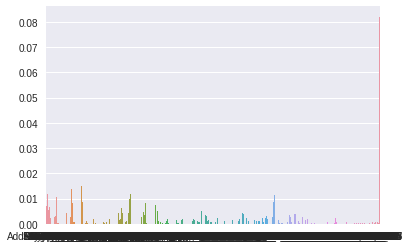

In [524]:
# Zipping feature importances and sorting by how importnat they are
#importances = list(zip(train.columns,model.feature_importances_))
importances = list(zip(best_features,model.feature_importances_))
importances.sort(key=lambda a: a[1])
importances = importances[::-1]
# std = np.std([model.feature_importances_ for tree in model.estimators_],
#              axis=0)

# Print the feature ranking
print("Feature ranking:")

for f in range(0, len(importances)):
    print("{}: {}".format(importances[f][0], importances[f][1]))

# Plot the feature importances of the forest
sns.barplot(x=train.columns, y=model.feature_importances_)


In [525]:
best_features = [ x[0] for x in list(filter(lambda a : a[1] >0, importances))]

In [ ]:
len(best_features)

In [ ]:
set(best_features) - set(train.columns)

In [ ]:
for x in set(best_features) - set(train.columns):
    best_features.remove(x) 

In [ ]:
set(best_features) - set(train.columns)

In [ ]:
best_features.append('spray_2')

In [ ]:
best_features